In [1]:
# Библиотеки, данные
import pandas as pd
import random
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation, ensemble, tree, metrics, svm, linear_model
from sklearn.grid_search import GridSearchCV
data=pd.read_csv("base_train.csv", sep=";")

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Определения

### Выборки

In [3]:
# Основная выборка
data.report_dt=data.report_dt.apply(pd.to_datetime)
data['month']=data.report_dt.apply(lambda x: x.month) #добавляется признак "месяц"

## 1. Анализ выборки.
### 1.1. Анализ признаков

In [6]:
print data.columns

Index([u'report_dt', u'ID', u'1.1.', u'1.2.', u'1.3.', u'1.4.', u'1.5.',
       u'1.6.', u'1.7.', u'1.8.', u'1.9.', u'1.10.', u'1.11.', u'1.12.',
       u'1.13.', u'1.14.', u'1.15.', u'1.16.', u'1.17.', u'1.18.', u'1.19.',
       u'2.1.', u'2.2.', u'2.3.', u'2.4.', u'2.5.', u'2.6.', u'2.7.', u'2.8.',
       u'2.9.', u'2.10.', u'2.11.', u'2.12.', u'2.13.', u'2.14.', u'2.15.',
       u'2.16.', u'3.1.', u'3.2.', u'3.3.', u'3.4.', u'3.5.', u'3.6.', u'3.7.',
       u'3.8.', u'3.9.', u'3.10.', u'3.11.', u'3.12.', u'3.13.', u'3.14.',
       u'3.15.', u'X3', u'Y3', u'month'],
      dtype='object')


In [4]:
for i in range(2,len(data.columns)):
    print i, data.columns[i], np.sum(data[data.columns[i]])

2 1.1. 880
3 1.2. 171
4 1.3. 2667
5 1.4. 939
6 1.5. 9869
7 1.6. 900
8 1.7. 870
9 1.8. 1381
10 1.9. 729
11 1.10. 734
12 1.11. 174
13 1.12. 756
14 1.13. 551
15 1.14. 4847
16 1.15. 19403
17 1.16. 974
18 1.17. 2773
19 1.18. 869
20 1.19. 1490
21 2.1. 651
22 2.2. 171
23 2.3. 1775
24 2.4. 5747
25 2.5. 32
26 2.6. 437
27 2.7. 983
28 2.8. 939
29 2.9. 562
30 2.10. 381
31 2.11. 22
32 2.12. 0
33 2.13. 8
34 2.14. 722
35 2.15. 153
36 2.16. 522
37 3.1. 1088
38 3.2. 328
39 3.3. 2194
40 3.4. 15
41 3.5. 169
42 3.6. 55
43 3.7. 318
44 3.8. 259
45 3.9. 299
46 3.10. 219
47 3.11. 272
48 3.12. 6
49 3.13. 40
50 3.14. 8
51 3.15. 44
52 X3 966.0
53 Y3 669.0
54 month 265680


In [5]:
# Признак "2.12." несет одни и те же значения для всех объектов. Можно удалить из выборки.
print data.columns[32], np.sum(data[data.columns[32]])

2.12. 0


In [6]:
data.drop("2.12.", axis=1, inplace=True)
print data.shape

(42602, 54)


## 2. Подготовка выборки
### 2.1. Пропущенные данные

In [7]:
# пропуски содержат только столбцы Х3 и Y3
# пропуски занимают 27% данных
data_na=data[data.X3.isnull()]
print data_na.shape, float(len(data_na)*100/len(data)),"%"

(11519, 54) 27.0 %


In [8]:
# Выборка пропусков значений X3 и Y3 от поля report_dt
unique_dates=data.report_dt[data.X3.isnull()].value_counts()-data.report_dt.value_counts()
data_na_dates=data[data.report_dt==unique_dates.index[unique_dates==0][0]]
for i in range(1,len(unique_dates.index[unique_dates==0])):      
    data_na_dates=data_na_dates.append(data[data.report_dt==unique_dates.index[unique_dates==0][i]])    
print data_na_dates.shape, float(len(data_na_dates)*100/len(data)),"% пропусков сосредоточены в признаке дата. Полностью отсутствуют значения в месяцах: февраль, апрель и сентябрь (кроме сентября 2015 года)"


(10304, 54) 24.0 % пропусков сосредоточены в признаке дата. Полностью отсутствуют значения в месяцах: февраль, апрель и сентябрь (кроме сентября 2015 года)


In [9]:
# Выборка пропусков значений X3 и Y3 от поля ID
unique_ID=data.ID[data.X3.isnull()].value_counts()-data.ID.value_counts()
data_na_ID=data[data.ID==unique_ID.index[unique_ID==0][0]]
for i in range(1,len(unique_ID.index[unique_ID==0])):      
    data_na_ID=data_na_ID.append(data[data.ID==unique_ID.index[unique_ID==0][i]])    
print data_na_ID.shape, float(len(data_na_ID)*100/len(data)),"%,", i+1, "из", len(unique_ID.index),"уникальных отчетов не имеют совсем никаких объектов. с общим количеством (пустых) объектов", data_na_ID.shape[0] 

(111, 54) 0.0 %, 59 из 1599 уникальных отчетов не имеют совсем никаких объектов. с общим количеством (пустых) объектов 111


In [10]:
# выборка для проведения resampling по ID (-111 NaN объектов)
data_sampling=data.drop(data_na_ID.index, axis=0, inplace=False)
print data.shape
print data_sampling.shape
print data.shape[0]-data_sampling.shape[0], data.ID.value_counts().shape[0]-data_sampling.ID.value_counts().shape[0]

(42602, 54)
(42491, 54)
111 59


### 2.1.1. Resampling by ID

In [11]:
# Заполнение пропусков в данных случайным образом соседними значениями по группе. Группировка по полю ID. 
# Т.е. копируются значения с одинковыми ID

data_resampled=pd.DataFrame()
for i in range(len(data_sampling.ID.unique())):    
    unique_ID_sampling=data_sampling[data_sampling.ID==data_sampling.ID.unique()[i]]
    random_choice_X=unique_ID_sampling[unique_ID_sampling.X3.notnull()].X3
    random_choice_Y=unique_ID_sampling[unique_ID_sampling.Y3.notnull()].Y3
    unique_ID_sampling.X3.fillna(random.choice(random_choice_X.values), inplace=True)
    unique_ID_sampling.Y3.fillna(random.choice(random_choice_Y.values), inplace=True)    
    data_resampled=data_resampled.append(unique_ID_sampling)
data_resampled['clastr']=(data_resampled.X3+data_resampled.Y3)
print data_resampled.shape
print "Остались пропуски?", data_resampled.isnull().values.any()

C:\Anaconda2\lib\site-packages\pandas\core\generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(42491, 55)
Остались пропуски? False


### 2.1.5. Выборка с удалением пропусков

In [12]:
data_w_na=data.dropna()
print data_w_na.shape

(31083, 54)


### 2.2. Балансировка, стратификация и масштабирование

In [13]:
print "Не существует X3=0, при Y3=1.", "Сумма всех X3|(Y3=1)=", np.sum(data.X3[data.Y3==1]), "всего (Y3=1)=", np.sum(data.Y3==1)
print "-------------------"
print "начальная выборка:", "X3=0", np.sum(data.X3==0), np.round(np.sum(data.X3==0)*100./np.size(data.X3),2), "%"
print "начальная выборка:", "Y3=0", np.sum(data.Y3==0), np.round(np.sum(data.Y3==0)*100./np.size(data.X3),2), "%"
print "начальная выборка:", "X3=1", np.sum(data.X3==1), np.round(np.sum(data.X3==1)*100./np.size(data.X3),2), "%"
print "начальная выборка:", "Y3=1", np.sum(data.Y3==1), np.round(np.sum(data.Y3==1)*100./np.size(data.X3),2), "%"
x_nan=np.size(data.X3)-np.sum(data.X3==0)-np.sum(data.X3==1)
y_nan=np.size(data.Y3)-np.sum(data.Y3==0)-np.sum(data.Y3==1)
print "начальная выборка:", "X3=NaN", x_nan, np.round(x_nan*100./np.size(data.X3),2), "%"
print "начальная выборка:", "Y3=NaN", y_nan, np.round(y_nan*100./np.size(data.X3),2), "%"
print "---"
print "т.е. p(X3|Y3)=1, p(X3)=", np.round(np.sum(data.X3==1)*1./np.size(data.X3),4), ",p(Y3)=", np.round(np.sum(data.Y3==1)*1./np.size(data.Y3),4)
p_y3_data=np.round(np.sum((data.Y3==1)*1./np.size(data.Y3))/np.sum((data.X3==1)*1./np.size(data.X3)),4)
print "тогда, p(Y3|X3)=p(Y3)/p(X3)= ",p_y3_data
print "-------------------"

print "выборка с удалением пропусков:", "X3=0", np.sum(data_w_na.X3==0), np.round(np.sum(data_w_na.X3==0)*100./np.size(data_w_na.X3),2), "%"
print "выборка с удалением пропусков:", "Y3=0", np.sum(data_w_na.Y3==0), np.round(np.sum(data_w_na.Y3==0)*100./np.size(data_w_na.X3),2), "%"
print "выборка с удалением пропусков:", "X3=1", np.sum(data_w_na.X3==1), np.round(np.sum(data_w_na.X3==1)*100./np.size(data_w_na.X3),2), "%"
print "выборка с удалением пропусков:", "Y3=1", np.sum(data_w_na.Y3==1), np.round(np.sum(data_w_na.Y3==1)*100./np.size(data_w_na.X3),2), "%"
x_nan=np.size(data_w_na.X3)-np.sum(data_w_na.X3==0)-np.sum(data_w_na.X3==1)
y_nan=np.size(data_w_na.Y3)-np.sum(data_w_na.Y3==0)-np.sum(data_w_na.Y3==1)
print "выборка с удалением пропусков:", "X3=NaN", x_nan, np.round(x_nan*100./np.size(data_w_na.X3),2), "%"
print "выборка с удалением пропусков:", "Y3=NaN", y_nan, np.round(y_nan*100./np.size(data_w_na.X3),2), "%"
print "---"
print "т.е. p(X3|Y3)=1, p(X3)=", np.round(np.sum(data_w_na.X3==1)*1./np.size(data_w_na.X3),4), ",p(Y3)=", np.round(np.sum(data_w_na.Y3==1)*1./np.size(data_w_na.Y3),4)
p_y3_data_na=np.round(np.sum((data_w_na.Y3==1)*1./np.size(data_w_na.Y3))/np.sum((data_w_na.X3==1)*1./np.size(data_w_na.X3)),4)
print "тогда, p(Y3|X3)=p(Y3)/p(X3)= ",p_y3_data_na
print "-------------------"

print "resampling:", "X3=0", np.sum(data_resampled.X3==0), np.round(np.sum(data_resampled.X3==0)*100./np.size(data_resampled.X3),2), "%"
print "resampling:", "Y3=0", np.sum(data_resampled.Y3==0), np.round(np.sum(data_resampled.Y3==0)*100./np.size(data_resampled.X3),2), "%"
print "resampling:", "X3=1", np.sum(data_resampled.X3==1), np.round(np.sum(data_resampled.X3==1)*100./np.size(data_resampled.X3),2), "%"
print "resampling:", "Y3=1", np.sum(data_resampled.Y3==1), np.round(np.sum(data_resampled.Y3==1)*100./np.size(data_resampled.X3),2), "%"
x_nan=np.size(data_resampled.X3)-np.sum(data_resampled.X3==0)-np.sum(data_resampled.X3==1)
y_nan=np.size(data_resampled.Y3)-np.sum(data_resampled.Y3==0)-np.sum(data_resampled.Y3==1)
print "resampling:", "X3=NaN", x_nan, np.round(x_nan*100./np.size(data_resampled.X3),2), "%"
print "resampling:", "Y3=NaN", y_nan, np.round(y_nan*100./np.size(data_resampled.X3),2), "%"
print "---"
print "т.е. p(X3|Y3)=1, p(X3)=", np.round(np.sum(data_resampled.X3==1)*1./np.size(data_resampled.X3),4), ",p(Y3)=", np.round(np.sum(data_resampled.Y3==1)*1./np.size(data_resampled.Y3),4)
p_y3_resampled=np.round(np.sum((data_resampled.Y3==1)*1./np.size(data_resampled.Y3))/np.sum((data_resampled.X3==1)*1./np.size(data_resampled.X3)),4)
print "тогда, p(Y3|X3)=p(Y3)/p(X3)= ",p_y3_resampled, "- далее это значение используется для предсказания выборки Y3 по X3"


Не существует X3=0, при Y3=1. Сумма всех X3|(Y3=1)= 669.0 всего (Y3=1)= 669
-------------------
начальная выборка: X3=0 30117 70.69 %
начальная выборка: Y3=0 30414 71.39 %
начальная выборка: X3=1 966 2.27 %
начальная выборка: Y3=1 669 1.57 %
начальная выборка: X3=NaN 11519 27.04 %
начальная выборка: Y3=NaN 11519 27.04 %
---
т.е. p(X3|Y3)=1, p(X3)= 0.0227 ,p(Y3)= 0.0157
тогда, p(Y3|X3)=p(Y3)/p(X3)=  0.6925
-------------------
выборка с удалением пропусков: X3=0 30117 96.89 %
выборка с удалением пропусков: Y3=0 30414 97.85 %
выборка с удалением пропусков: X3=1 966 3.11 %
выборка с удалением пропусков: Y3=1 669 2.15 %
выборка с удалением пропусков: X3=NaN 0 0.0 %
выборка с удалением пропусков: Y3=NaN 0 0.0 %
---
т.е. p(X3|Y3)=1, p(X3)= 0.0311 ,p(Y3)= 0.0215
тогда, p(Y3|X3)=p(Y3)/p(X3)=  0.6925
-------------------
resampling: X3=0 41162 96.87 %
resampling: Y3=0 41621 97.95 %
resampling: X3=1 1329 3.13 %
resampling: Y3=1 870 2.05 %
resampling: X3=NaN 0 0.0 %
resampling: Y3=NaN 0 0.0 %
---
т

В то время как выборке присутствуют 2 целевые переменные, в процессе исследования было решено отказаться от задачи многоклассовой классификации. А рассмартивать задачу классификации по переменной X3 и затем по формуле Байеса по условным вероятностям предсказывать целевую переменную Y3. Это связано с особенностью выборки: не существует X3=0, при Y3=1. Т.е. Y3=1 только если Х3 уже = 1. Подобная ситуация характерна для скоринговой модели, гда в качестве переменных Х3 и Y3 могут выступать данные об уровне просрочки, н-р, Х3= +5 дней просрочки, Y3=+30 дней (условно). Y3 не может существовать до появления Х3. По крайней мере в рамках имеющихся наблюдений. Дополнительных описательных данных нет. 

In [14]:
# масштабирование признаков (месяц)
X_resampled=pd.DataFrame
X_resampled=data_resampled.drop(["report_dt","ID","X3","Y3","clastr"], axis=1)
X_resampled=X_resampled.values
Y_resampled=data_resampled.clastr.values
print X_resampled.shape, Y_resampled.shape

scaler=StandardScaler()
scaler.fit(X_resampled, Y_resampled)
X_resampled_scaled=scaler.transform(X_resampled)

(42491L, 50L) (42491L,)


C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [15]:
print X_resampled_scaled[0]

[-0.14542439 -0.06356605 -0.25837061 -0.15032694 -0.54987836 -0.14710301
 -0.14457839 -0.18314617 -0.13212139 -0.13258164 -0.0641235  -0.13458935
  8.72445714  2.78780967  1.09176579 -0.15316746 -0.26351518 -0.14449353
 -0.19063205 -0.12473682 -0.06356605 -0.20879333 -0.39540302 -0.02745302
 -0.10193822 -0.15389016 -0.15032694 -0.11577396 -0.09423388 -0.02276016
 -0.01372263 -0.13147451 -0.06011468 -0.11152467 -0.1621058  -0.08806493
 -0.23333611 -0.01879204 -0.06319173 -0.03600096 -0.0868353  -0.07831213
 -0.08418225 -0.07197732 -0.08026579 -0.01188387 -0.0306963  -0.01372263
 -0.03219607 -0.67058205]


### Отсев признаков

In [16]:
# выявление несущественных признаков 
etc=ensemble.ExtraTreesClassifier(class_weight="balanced", n_estimators=30, bootstrap=True, random_state=3, n_jobs=-1, )
etc.fit(X_resampled_scaled, Y_resampled)
for i in range(len(etc.feature_importances_)):
    print i, data_resampled.drop(["report_dt","ID","X3","Y3","clastr"], axis=1, inplace=False).columns[i], etc.feature_importances_[np.round(i,2)]

0 1.1. 0.0331428972434
1 1.2. 0.00304166542608
2 1.3. 0.0141696982406
3 1.4. 0.0066980936814
4 1.5. 0.0274272916352
5 1.6. 0.00394945633867
6 1.7. 0.00417270753707
7 1.8. 0.0115128375542
8 1.9. 0.00486842579486
9 1.10. 0.0106031189272
10 1.11. 0.00165082976193
11 1.12. 0.00385882157041
12 1.13. 0.00585216148256
13 1.14. 0.0329880947747
14 1.15. 0.0300387054219
15 1.16. 0.0151090820702
16 1.17. 0.0579466996983
17 1.18. 0.00269468238136
18 1.19. 0.00690142865918
19 2.1. 0.0380504333923
20 2.2. 0.00399453921541
21 2.3. 0.0339145345275
22 2.4. 0.0314921571526
23 2.5. 0.00253886628322
24 2.6. 0.00333486779317
25 2.7. 0.00947815648158
26 2.8. 0.020199682752
27 2.9. 0.017137097177
28 2.10. 0.00563287034515
29 2.11. 8.44716430028e-05
30 2.13. 1.95036382643e-05
31 2.14. 0.00990752699577
32 2.15. 0.0032341715848
33 2.16. 0.00807810031308
34 3.1. 0.218874279972
35 3.2. 0.0376439301011
36 3.3. 0.0173580672756
37 3.4. 0.00216398549527
38 3.5. 0.0106048772352
39 3.6. 0.00451889025374
40 3.7. 0.01552

In [17]:
# удаление несущественных признаков и повторное формирование выборки с последующим масштабированием
X_resampled=pd.DataFrame
X_resampled=data_resampled.drop(["report_dt","ID","X3","Y3","clastr","2.5.","2.11.","2.13.","3.4.","3.6.","3.12.","3.13.","3.14.","3.15."], axis=1)
X_resampled=X_resampled.values
Y_resampled=data_resampled.clastr.values
#Y_resampled=Y_resampled.reshape((len(data_resampled.clastr.values),1))
print X_resampled.shape, Y_resampled.shape

scaler=StandardScaler()
scaler.fit(X_resampled, Y_resampled)
X_resampled_scaled=scaler.transform(X_resampled)

(42491L, 41L) (42491L,)


C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Train / test / validation

In [18]:
# Разбиение выборки на обучение / тест. Подвыборки стратифицированы. Балансировка производится через атрибут (class_weight="balanced")
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(X_resampled_scaled,
                                                                                     Y_resampled, test_size = 0.3,
                                                                                     stratify=Y_resampled, random_state=3)
#Для создания одинаковой выборки для 2-х целевых переменных, была введена промежуточная переменная "clastr".
# разделяем "clastr" на X3 и Y3
mapping_X3 = {2.0 : 1, 1.0: 1, 0.0: 0}
train_labels_X3 = [mapping_X3[i] for i in train_labels]
test_labels_X3 = [mapping_X3[i] for i in test_labels]

mapping_Y3 = {2.0 : 1, 1.0: 0, 0.0: 0}
train_labels_Y3 = [mapping_Y3[i] for i in train_labels]
test_labels_Y3 = [mapping_Y3[i] for i in test_labels]

#параметр кросс-валидации для перебора по сетке GridSearch.
cv = cross_validation.StratifiedShuffleSplit(train_labels_X3, n_iter = 10, test_size = 0.2, random_state = 0)

### Logistic Regression

В качестве рабочей модели была выбрана Logistic Regression как показавшая наилучшие результаты на тестах. Так же приемлимо отработала (recall>80) модель Rendom Forest. Тесты остальных моделей в файле Working.

Для целей оценки качества была выбрана метрика полноты (recall) класса 1 переменной Х3. Выбор обусловлен особенностью основной выборки, а именно: значительная несбалансированность меток классов целевой переменной (класс-0 ~ 97%, класс - 1 ~3%). Эта несбалансированность повышает значимость предсказания малого класса в ущерб точности (preccision). При том, что точность (preccision) из-за непропорционального размера класса 0, стабильно выше 0,95 Подобные  задачи характерны, н-р, для обнаружения мошеннеческих операций (которых также не много в общей массе операций). "Цена ошибки" не распознать редкое мошеннеческое действие выше "цены ошибки" принять обычную операцию за мошеннеческую.

In [19]:
model_4=linear_model.LogisticRegression(class_weight="balanced",random_state=3, n_jobs=-1)
#linear_model.LogisticRegression()
model_4.fit(train_data, train_labels_X3)
model_4_pred_X3=model_4.predict_proba(test_data)
model_4_pred_Y3=np.round(model_4_pred_X3[:,1]*p_y3_resampled)

In [20]:
def plot_scores_C(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=3,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.828571428571
{'penalty': 'l2', 'C': 0.001}
[mean: 0.77407, std: 0.04312, params: {'penalty': 'l1', 'C': 0.001}, mean: 0.82857, std: 0.03750, params: {'penalty': 'l2', 'C': 0.001}, mean: 0.81323, std: 0.03967, params: {'penalty': 'l1', 'C': 0.005}, mean: 0.82698, std: 0.03262, params: {'penalty': 'l2', 'C': 0.005}, mean: 0.82646, std: 0.03403, params: {'penalty': 'l1', 'C': 0.01}, mean: 0.82698, std: 0.03262, params: {'penalty': 'l2', 'C': 0.01}, mean: 0.82646, std: 0.03260, params: {'penalty': 'l1', 'C': 0.05}, mean: 0.82698, std: 0.03262, params: {'penalty': 'l2', 'C': 0.05}, mean: 0.82646, std: 0.03260, params: {'penalty': 'l1', 'C': 0.1}, mean: 0.82698, std: 0.03262, params: {'penalty': 'l2', 'C': 0.1}, mean: 0.826

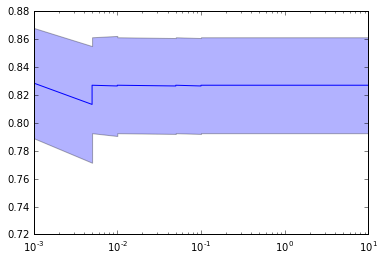

In [21]:
parameters_grid_4 = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
                  'penalty' : ['l1', 'l2'],}

opt_4=GridSearchCV(model_4, param_grid=parameters_grid_4, cv=cv, scoring="recall")
opt_4.fit(train_data, train_labels_X3)

opt_4_pred = opt_4.predict(test_data)

print opt_4.best_estimator_
print opt_4.best_score_
print opt_4.best_params_
print opt_4.grid_scores_
plot_scores_C(opt_4)

In [22]:
model_4_b=linear_model.LogisticRegression(class_weight="balanced", n_jobs=-1, random_state=3,
                                          C=opt_4.best_params_['C'], penalty=opt_4.best_params_['penalty'])
model_4_b.fit(train_data, train_labels_X3)
model_4_b_pred_X3=model_4_b.predict_proba(test_data)
model_4_b_pred_Y3=np.round(model_4_b_pred_X3[:,1]*p_y3_resampled)

In [23]:
print "recall_X3_train:", metrics.recall_score(test_labels_X3, model_4.predict(test_data))
print "recall_Y3_train:", metrics.recall_score(test_labels_Y3, model_4_pred_Y3)
print metrics.classification_report(test_labels_X3, model_4.predict(test_data))

print "--------------"
print "recall_X3_test:", metrics.recall_score(test_labels_X3, model_4_b.predict(test_data))
print "recall_Y3_test:", metrics.recall_score(test_labels_Y3, model_4_b_pred_Y3)
print metrics.classification_report(test_labels_X3, model_4_b.predict(test_data))

recall_X3_train: 0.859259259259
recall_Y3_train: 0.90157480315
             precision    recall  f1-score   support

          0       1.00      0.93      0.96     12343
          1       0.30      0.86      0.44       405

avg / total       0.97      0.93      0.95     12748

--------------
recall_X3_test: 0.861728395062
recall_Y3_test: 0.897637795276
             precision    recall  f1-score   support

          0       1.00      0.93      0.96     12343
          1       0.29      0.86      0.43       405

avg / total       0.97      0.93      0.95     12748

